In [73]:
import matplotlib.pyplot as plt
import cv2

In [74]:
img = cv2.imread("images/conceito.jpeg")

In [75]:
def channel_first(img):
    return [[[img[j][k][i] for k in range(len(img[0]))]
             for j in range(len(img))] for i in range(len(img[0][0]))]

def channel_last(img):
    return [[[img[k][i][j] for k in range(len(img))]
             for j in range(len(img[0][0]))] for i in range(len(img[0]))]
 
def electronic_wave_effect(img, strength=5, bgvalue=0):
    temp = channel_first(img)
    R = pad(channel_last([temp[0]]), (0, 2 * strength, 2 * strength, 0),
            bgvalue)

    G = pad(channel_last([temp[1]]), (strength, strength, strength, strength),
            bgvalue)

    B = pad(channel_last([temp[2]]), (2 * strength, 0, 0, 2 * strength),
            bgvalue)

    return channel_last(channel_first(R) + channel_first(G) + channel_first(B))

def pad(img, left_right_top_bottom, value=0):
    temp1 = img.copy()
    for i in range(left_right_top_bottom[2]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[3]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_right(temp1)
    for i in range(left_right_top_bottom[0]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[1]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_left(temp1)
    return temp1

def rotate_left(img):
    return [[[img[j][-1-i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

#rotate right
def rotate_right(img):
    return [[[img[-1 - j][i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

C:\Users\Thiago\AppData\Local\Temp\ipykernel_6940\2709147156.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  return [[img1[i][j] + img2[i][j] for j in range(len(img1[0]))]


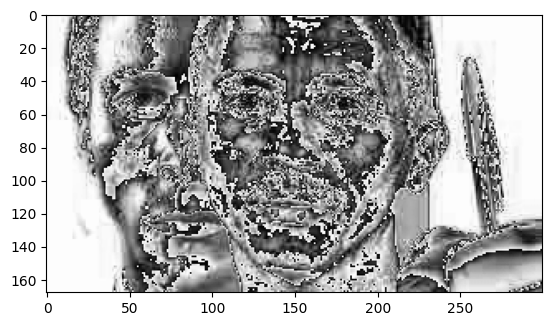

In [81]:
def add_list(img1, img2):
    return [[img1[i][j] + img2[i][j] for j in range(len(img1[0]))]
            for i in range(len(img1))]

def channel_wise_addition(img):
    temp = channel_first(img)
    return add_list(temp[2], add_list(temp[0], temp[1]))


plt.imshow(channel_wise_addition(img), cmap="gray")
plt.show()

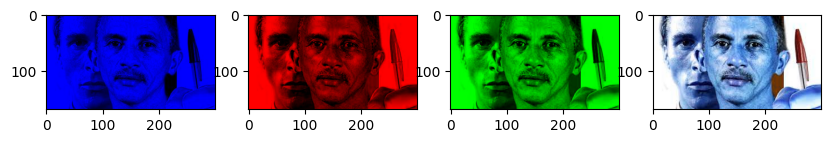

In [77]:
fig = plt.figure(figsize=(10, 7))

for i in range(3):
    copia = img.copy()
    copia[:,:,i] = 0
    copia[:,:,(i+1)%3] = 0

    fig.add_subplot(1, 4, i+1)
    plt.imshow(copia)

fig.add_subplot(1, 4, 4)
plt.imshow(img, cmap="gray")

plt.show()

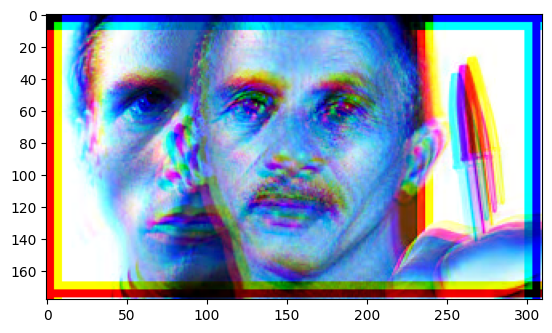

In [79]:
plt.imshow(electronic_wave_effect(img))
plt.show()

# Fazer blur